In [364]:
import pandas as pd
import numpy as np

from volsurface.surface_analysis.var_swap import VolFactorModel

load_df = True
if load_df:
    sabr_params = pd.read_clipboard()

In [365]:
sabr_params['days'] = sabr_params['Time'] * 365
sabr_params

,Contract,Time,DF,Fwrd,ATMVol,Beta,Rho,Nu,days
0,SFRH3,0.16,0.9925,0.049,50.6,0,-0.25,1.47,58.40
1,SFRM3,0.43,0.9796,0.049,68.6,0,-0.25,1.19,156.95
2,SFRU3,0.68,0.9676,0.047,93.0,0,-0.25,0.94,248.20
3,SFRZ3,0.93,0.9562,0.043,111.6,0,-0.24,0.77,339.45
4,SFRH4,1.18,0.9458,0.039,124.4,0,-0.18,0.65,430.70
5,SFRM4,1.43,0.9367,0.034,130.4,0,-0.10,0.56,521.95
6,SFRU4,1.68,0.9287,0.031,133.8,0,-0.04,0.51,613.20
7,SFRZ4,1.93,0.9215,0.030,135.1,0,0.01,0.48,704.45
8,SFRH5,2.18,0.9147,0.029,134.6,0,0.06,0.45,795.70
9,SFRM5,2.43,0.9082,0.029,133.3,0,0.11,0.42,886.95


array([0.48569316, 3.91780822])

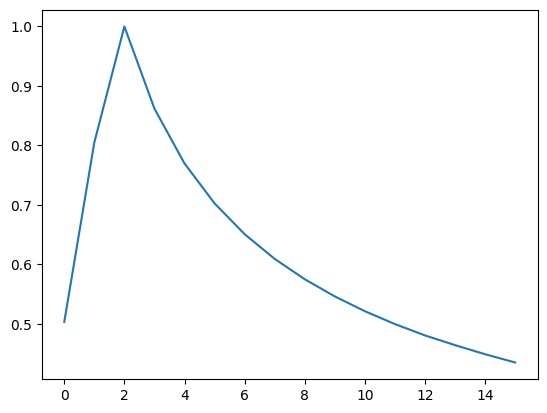

In [366]:
from volsurface.surface_analysis.var_swap import fit_vol_term_struct, TermStructureParams
from scipy.optimize import fmin_l_bfgs_b

column = 'ATMVol'

lower_inflection,  upper_inflection = 248, 1069
w =  np.exp(np.log(0.5) * np.abs(np.log(sabr_params.days) - np.log(lower_inflection)) / ( np.log(upper_inflection) - np.log(lower_inflection) ) )
w.plot()

#w=np.ones(len(sabr_params.days))
def f(x):
    t1, t2 = x[0], x[1]
    fixed_mty_mkt_tau_vec = sabr_params['days']
    atm_fit_output = fit_vol_term_struct(
                fixed_mty_mkt_tau_vec, sabr_params[column], w=w, T1=t1, T2=t2)
    error = np.dot(sabr_params[column] - atm_fit_output["vol_vec_hat"], sabr_params[column] - atm_fit_output["vol_vec_hat"])
    # print(f'Avg zerror: {np.sqrt(error)}, with {t1}, {t2}')
    return error

point, error, data = fmin_l_bfgs_b(f, [lower_inflection, upper_inflection], bounds=[(0, 1430), (0, 1430)], approx_grad=True)
point / 365

array([ 20.5797101 , 135.54736439, 163.11764578])

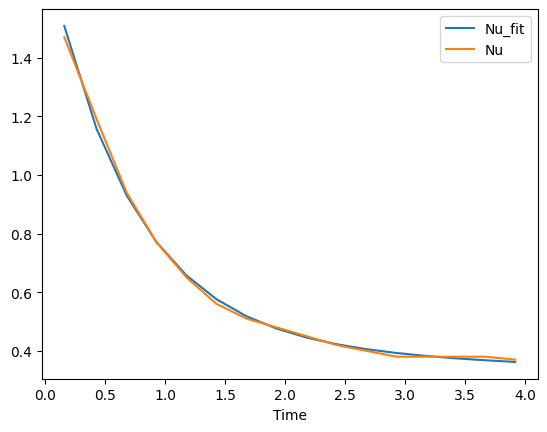

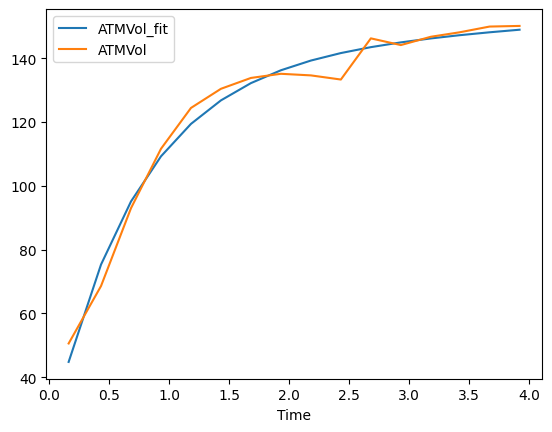

In [367]:
t1, t2 = point

for column in  ['Nu', 'ATMVol']:
    atm_fit_output = fit_vol_term_struct(
                    sabr_params['days'], sabr_params[column], w=w, T_days_floor=0, T1=t1, T2=t2)
    sabr_params[f'{column}_fit'] = atm_fit_output['vol_vec_hat']
    sabr_params.plot(x='Time', y=[f'{column}_fit', column])
    sabr_params.to_clipboard()

pd.DataFrame(atm_fit_output['factor_matrix'], index=sabr_params.index).to_clipboard()
atm_fit_output['f']

In [368]:
from volsurface.automatic_calibration.calibration_parameters import CalibrationParametersStruct
from volsurface.vol_surface_enums import TimeInterpolationType
from volsurface.interpolation import Interpolation
from volsurface.volsurface import VolSurface

from volsurface.model_parameters import ZABRModelParameters
from volsurface.forward_curve import ForwardCurve, ZeroCurve

oder = ['ATMVol', 'Beta', 'Rho', 'Nu', 'ZNu']
scale = {'ATMVol': 0.0001 }

sabr_params['rf'] = sabr_params.apply(lambda row: np.log(row['Fwrd'])/row['Time'], axis=1)

model_params = [ZABRModelParameters( [ row[-1].get(o,0) * scale.get(o, 1.0) for o in oder] ) for row in sabr_params.iterrows() ]
fwd_curve = ForwardCurve(1.0, ZeroCurve( list(sabr_params.Time), list(sabr_params.rf) ), ZeroCurve.build_with_zero(time = 0.0))
vol_surf = VolSurface(
    Interpolation.build_interpolation(TimeInterpolationType.ModelParametersInterpolation, CalibrationParametersStruct(), True),
    Interpolation(True),
    Interpolation(True),
    model_params,
    sabr_params.Time.values,
    fwd_curve)

In [369]:
days = 50
factor_matrix = VolFactorModel.calc_vol_factor_model(sabr_params.days - days, t1, t2)

sabr_params[f'time_{days}days'] = (sabr_params.days - days)/365
sabr_params[f'ATMVol_{days}days']= np.dot(factor_matrix, atm_fit_output['f'])

fwds = [vol_surf.fwd_curve.get_fwd(t) for t in list(sabr_params[f'time_{days}days'])]
slided_vols = [ 100 * vol_surf.get_slice(t).get_vol(fwds[i]) for i, t in enumerate(list(sabr_params[f'time_{days}days']))]
sabr_params[f'Fwrds_{days}day'] = fwds
sabr_params[f'Slided_Vols_{days}day'] = slided_vols

In [370]:
sabr_params.set_index('Contract').to_clipboard()

In [482]:
get_correlation = False

if get_correlation:
    correlations = pd.read_clipboard()
    avg_times = [0.76, 2.1, 2.6]
    vols = vol_surf.get_vols(vol_surf.fwd_curve.get_fwd(avg_times), avg_times)
    vols_diag = np.diag(vols) * 100

np.matrix(correlations.values.astype(float)), vols_diag

(matrix([[1.        , 0.64407885, 0.58664345],
         [0.64407885, 1.        , 0.91082552],
         [0.58664345, 0.91082552, 1.        ]]),
 array([[100.69348131,   0.        ,   0.        ],
        [  0.        , 134.7472402 ,   0.        ],
        [  0.        ,   0.        , 142.46439274]]))

In [487]:
covariance = vols_diag * np.matrix(correlations.values.astype(float)) * vols_diag
covariance_for_model = np.matrix(factor_matrix) * covariance * np.matrix(factor_matrix).transpose()


pd.DataFrame(np.linalg.inv(covariance_for_model)).to_clipboard()

In [486]:
pd.DataFrame(covariance_for_model)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,10057.326645,9716.877759,9495.895501,9337.842881,9223.982585,9141.193574,9080.286050,9034.822053,9000.289951,8973.526636,8952.313097,8935.091338,8920.766235,8909.021417,8898.348864,8888.886417
1,9716.877759,10409.778904,10849.034562,11153.668106,11364.197981,11508.978786,11607.851569,11674.698752,11719.232375,11748.245725,11766.489370,11777.284313,11782.951144,11785.075917,11784.936378,11783.181679
2,9495.895501,10849.034562,11710.590159,12311.585177,12730.295187,13021.503400,13223.550309,13363.267895,13459.433201,13525.185561,13569.718475,13599.463789,13618.920522,13630.849473,13638.385822,13642.465180
3,9337.842881,11153.668106,12311.585177,13120.946862,13686.393301,14081.162671,14356.514229,14548.323723,14681.699685,14774.214485,14838.165817,14882.159575,14912.217733,14931.886722,14945.674904,14954.681523
4,9223.982585,11364.197981,12730.295187,13686.393301,14355.525806,14823.806759,15151.509397,15380.820336,15541.266923,15653.515975,15732.032606,15786.941213,15825.328017,15851.254321,15870.259560,15883.522243
5,9141.193574,11508.978786,13021.503400,14081.162671,14823.806759,15344.522436,15709.865090,15966.420207,16146.795771,16273.816495,16363.459470,16426.908902,16471.994273,16503.103759,16526.565394,16543.579418
6,9080.286050,11607.851569,13223.550309,14356.514229,15151.509397,15709.865090,16102.507934,16379.084820,16574.348274,16712.625738,16810.947735,16881.237359,16931.842760,16967.348849,16994.699650,17015.078330
7,9034.822053,11674.698752,13363.267895,14548.323723,15380.820336,15966.420207,16379.084820,16670.587104,16877.169436,17024.203746,17129.453254,17205.355450,17260.620016,17299.938899,17330.748532,17354.189243
8,9000.289951,11719.232375,13459.433201,14681.699685,15541.266923,16146.795771,16574.348274,16877.169436,17092.533731,17246.537162,17357.451356,17438.071189,17497.357957,17540.049190,17573.984578,17600.244914
9,8973.526636,11748.245725,13525.185561,14774.214485,15653.515975,16273.816495,16712.625738,17024.203746,17246.537162,17406.222098,17521.881793,17606.558726,17669.388938,17715.113799,17751.911318,17780.792346


In [502]:
read_fwd_vol = False

if read_fwd_vol:
    fwd_vol = pd.read_clipboard()
    fwd_vol = np.array(fwd_vol)

pd.DataFrame(np.linalg.inv(covariance_for_model) * fwd_vol / ( fwd_vol.transpose() * np.linalg.inv(covariance_for_model) * fwd_vol )).to_clipboard()